In [ ]:
!pip install -r requirements.txt

  Using cached ipython-7.31.1-py3-none-any.whl (792 kB)
  Attempting uninstall: ipython
    Found existing installation: ipython 8.5.0
    Not uninstalling ipython at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'ipython'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:

import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import geopandas as gpd
from collections import Counter
import geopandas as gpd
import json
import folium
from IPython.display import display
from shapely.geometry import shape
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import csv 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
%load_ext sql

The sql module is not an IPython extension.


In [ ]:
conn = sqlite3.connect('atsm.db')
cursor = conn.cursor()
# Grab question answers, overall score, and result from Child
query = "SELECT A1_Score, A2_Score,A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score, result, ASD FROM child"

# Execute the query and fetch the data into an array
cursor = conn.execute(query)
child_data = np.array(cursor.fetchall())


conn.close()
conn = sqlite3.connect('atsm.db')
cursor = conn.cursor()
# Grab question answers, overall score, and result from Adult
query = "SELECT A1_Score, A2_Score,A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score, result, ASD FROM adult"

# Execute the query and fetch the data into an array
cursor = conn.execute(query)
adult_data = np.array(cursor.fetchall())


conn.close()



In [ ]:

# Only get rows with their overall score in a reasonable range.
column_name = 'result'  
min_value = 1.0
max_value = 9.0

column_child_data = child_data[:, 10]  
column_child_data = column_child_data.astype(float)  

# Apply the filtering condition
child_data = child_data[(column_child_data >= min_value) & (column_child_data <= max_value)]

column_adult_data = adult_data[:, 10]  
column_adult_data = column_adult_data.astype(float)  

# Apply the filtering condition
adult_data = adult_data[(column_adult_data >= min_value) & (column_adult_data <= max_value)]

In [ ]:
def plot_feat_import(ax, feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
        
    # plot and label feature importance
    ax.barh(range(len(feat_list)), feat_import, align='center')
    ax.set_yticks(range(len(feat_list)))
    ax.set_yticklabels(feat_list)
    ax.set_xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

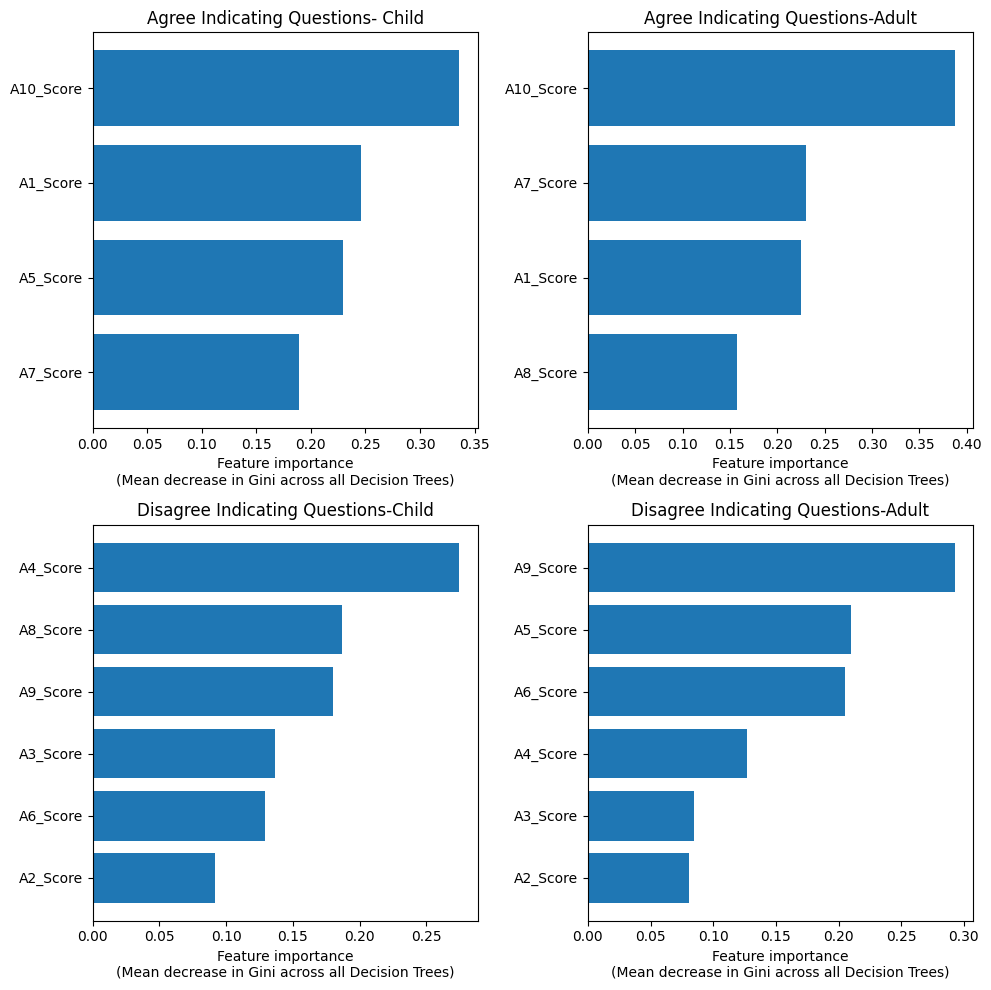

In [ ]:
y_feat = 'ASD' 


# Split the data based on the scoring criteria
child_agree_indices = [0,4,6,9]  
child_disagree_indices = [1,2,3,5,7,8]  
adult_agree_indices = [0,6,7,9]  
adult_disagree_indices = [1,2,3,4,5,8]  

# Create separate child_datasets for each subgroup
agree_child_data = child_data[:,child_agree_indices]
disagree_child_data = child_data[:,child_disagree_indices]
# Create separate child_datasets for each subgroup
agree_adult_data = adult_data[:,adult_agree_indices]
disagree_adult_data = adult_data[:,adult_disagree_indices]

# Create ASD target variables for each child subgroup
child_agree_target = child_data[:,11]
child_disagree_target = child_data[:,11]
child_agree_true = np.where(child_agree_target == 'YES', 1, 0)
child_disagree_true = np.where(child_disagree_target == 'YES', 1, 0)


adult_agree_target = adult_data[:,11]
adult_disagree_target = adult_data[:,11]
adult_agree_true = np.where(adult_agree_target == 'YES', 1, 0)
adult_disagree_true = np.where(adult_disagree_target == 'YES', 1, 0)


# Create random forest classifiers for each child subgroup
child_agree_rf = RandomForestClassifier()
child_disagree_rf = RandomForestClassifier()

# Fit the classifiers on the subgroup child_data
child_agree_rf.fit(agree_child_data, child_agree_target)
child_disagree_rf.fit(disagree_child_data, child_disagree_target)


child_agree_predictions = child_agree_rf.predict(agree_child_data)
child_disagree_predictions = child_disagree_rf.predict(disagree_child_data)

child_agree_feat_import = child_agree_rf.feature_importances_

# Plot feature importances for Agree Questions-Child
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plot_feat_import(axes[0, 0],feat_list=['A1_Score', 'A5_Score', 'A7_Score', 'A10_Score'], feat_import=child_agree_feat_import, sort=True, limit=None)
axes[0,0].set_title('Agree Indicating Questions- Child')

child_disagree_feat_import = child_disagree_rf.feature_importances_

# Plot feature importances for Disagree Questions-Child
plot_feat_import(axes[1,0],feat_list=['A2_Score','A3_Score', 'A4_Score', 'A6_Score', 'A8_Score','A9_Score'], feat_import=child_disagree_feat_import, sort=True, limit=None)
axes[1,0].set_title('Disagree Indicating Questions-Child')

# Create random forest classifiers for each Adult subgroup
adult_agree_rf = RandomForestClassifier()
adult_disagree_rf = RandomForestClassifier()

# Fit the classifiers on the subgroup adult_data
adult_agree_rf.fit(agree_adult_data, adult_agree_target)
adult_disagree_rf.fit(disagree_adult_data, adult_disagree_target)


adult_agree_predictions = adult_agree_rf.predict(agree_adult_data)
adult_disagree_predictions = adult_disagree_rf.predict(disagree_adult_data)

adult_agree_feat_import = adult_agree_rf.feature_importances_

# Plot feature importances for Agree Questions-Adult
plot_feat_import(axes[0, 1],feat_list=['A1_Score', 'A7_Score', 'A8_Score', 'A10_Score'], feat_import=adult_agree_feat_import, sort=True, limit=None)
axes[0,1].set_title('Agree Indicating Questions-Adult')


adult_disagree_feat_import = adult_disagree_rf.feature_importances_

# Plot feature importances for Disagree Questions-Adult
plot_feat_import(axes[1, 1], feat_list=['A2_Score','A3_Score', 'A4_Score', 'A5_Score', 'A6_Score','A9_Score'], feat_import=adult_disagree_feat_import, sort=True, limit=None)
axes[1,1].set_title('Disagree Indicating Questions-Adult')
plt.tight_layout()
plt.show()
fig.savefig('ASD-FI.png')

Agree Questions Average Accuracy-Child: 0.7122529644268775
Disagree Questions Average Accuracy-Child: 0.7960474308300396
Agree Questions Average Accuracy-adult: 0.7460526315789474
Disagree Questions Average Accuracy-adult: 0.8659774436090226


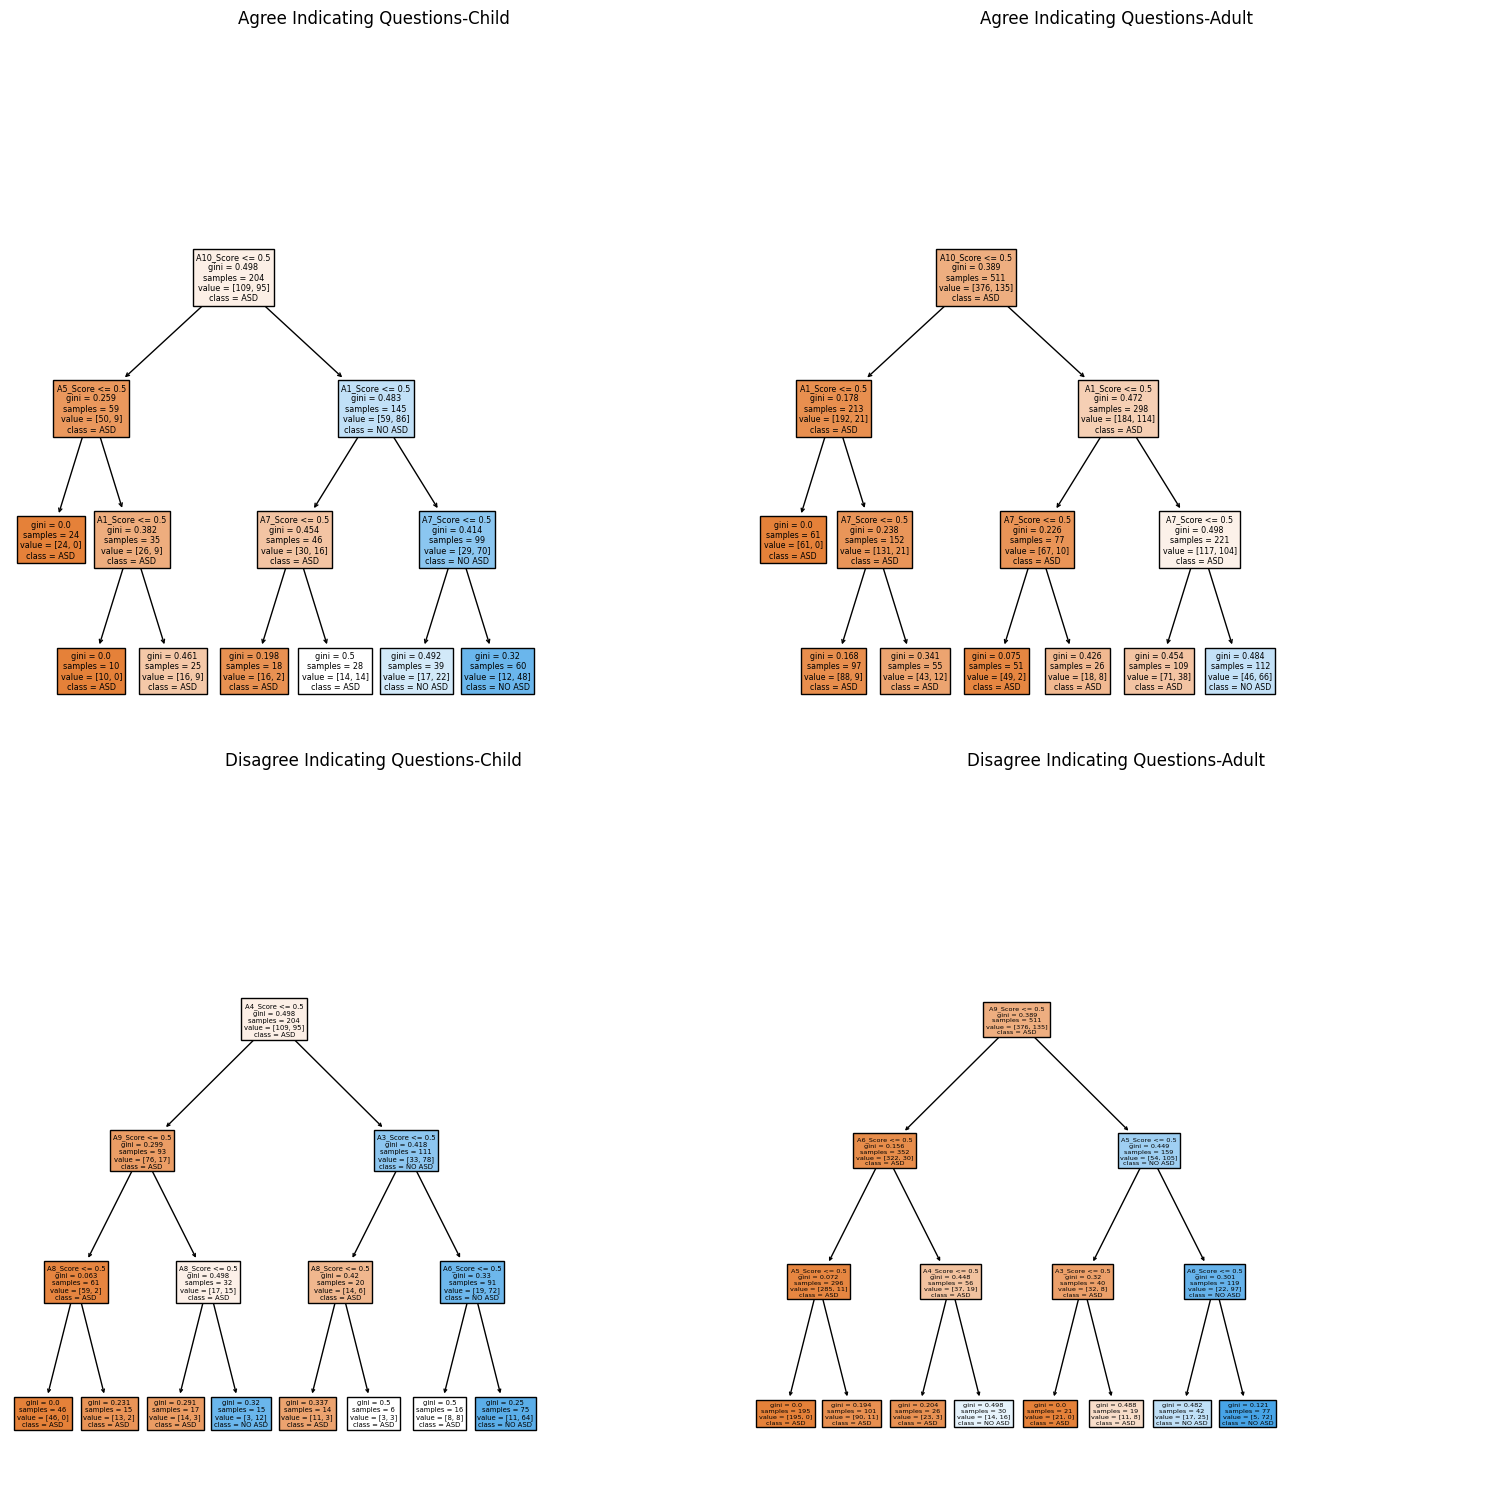

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Split the child_data based on the scoring criteria
child_agree_indices = [0,4,6,9]  
child_disagree_indices = [1,2,3,5,7,8]  
adult_agree_indices = [0,6,7,9]  
adult_disagree_indices = [1,2,3,4,5,8]   

# Create separate child_datasets for each subgroup
agree_child_data = child_data[:,child_agree_indices]
disagree_child_data = child_data[:,child_disagree_indices]

# Create separate adult_datasets for each subgroup
agree_adult_data = adult_data[:,adult_agree_indices]
disagree_adult_data = adult_data[:,adult_disagree_indices]

# Create ASD target variables for each child subgroup
child_agree_target = child_data[:,11]
child_disagree_target = child_data[:,11]
child_agree_true = np.where(child_agree_target == 'YES', 1, 0)
child_disagree_true = np.where(child_disagree_target == 'YES', 1, 0)


# Create separate decision tree classifiers for each child subgroup
child_agree_dt = DecisionTreeClassifier(max_depth=3)
child_disagree_dt = DecisionTreeClassifier(max_depth=3)

# Initialize StratifiedKFold object 
child_skfold = StratifiedKFold(n_splits=10)

child_agree_accuracies = []
child_disagree_accuracies = []
child_agree_cm = np.zeros((2, 2))
child_disagree_cm = np.zeros((2, 2))

# Perform cross-validation for Agree Questions-Child
for train_idx, test_idx in child_skfold.split(agree_child_data, child_agree_true):
    x_train, x_test = agree_child_data[train_idx], agree_child_data[test_idx]
    y_train, y_test = child_agree_target[train_idx], child_agree_target[test_idx]
    child_agree_dt.fit(x_train, y_train)
    child_agree_pred = child_agree_dt.predict(x_test)
    child_accuracy = np.mean(child_agree_pred == y_test)
    child_agree_accuracies.append(child_accuracy)
    child_agree_cm += confusion_matrix(y_test, child_agree_pred)

# Perform cross-validation for Disagree Questions-Child
for train_idx, test_idx in child_skfold.split(disagree_child_data, child_disagree_true):
    x_train, x_test = disagree_child_data[train_idx], disagree_child_data[test_idx]
    y_train, y_test = child_disagree_target[train_idx], child_disagree_target[test_idx]
    child_disagree_dt.fit(x_train, y_train)
    child_disagree_pred = child_disagree_dt.predict(x_test)
    child_accuracy = np.mean(child_disagree_pred == y_test)
    child_disagree_accuracies.append(child_accuracy)
    child_disagree_cm += confusion_matrix(y_test, child_disagree_pred)

# Calculate and print the average/overall accuracy for each child tree
child_agree_avg_accuracy = np.mean(child_agree_accuracies)
child_disagree_avg_accuracy = np.mean(child_disagree_accuracies)

print(f"Agree Questions Average Accuracy-Child: {child_agree_avg_accuracy}")
print(f"Disagree Questions Average Accuracy-Child: {child_disagree_avg_accuracy}")

# Plot the decision tree for Agree Questions-Child
tree.plot_tree(child_agree_dt,ax=axes[0,0], feature_names=['A1_Score', 'A5_Score', 'A7_Score', 'A10_Score'], class_names=['ASD', 'NO ASD'], filled=True, max_depth=3)
axes[0,0].set_title('Agree Indicating Questions-Child')


# Plot the decision tree for Disagree Questions-Child
tree.plot_tree(child_disagree_dt,ax=axes[1,0], feature_names=['A2_Score', 'A3_Score', 'A4_Score', 'A6_Score', 'A8_Score', 'A9_Score'], class_names=['ASD', 'NO ASD'], filled=True, max_depth=3)
axes[1,0].set_title('Disagree Indicating Questions-Child')

# Create ASD target variables for each Adult subgroup
adult_agree_target = adult_data[:,11]
adult_disagree_target = adult_data[:,11]
adult_agree_true = np.where(adult_agree_target == 'YES', 1, 0)
adult_disagree_true = np.where(adult_disagree_target == 'YES', 1, 0)

# Create separate decision tree classifiers for each Adult subgroup
adult_agree_dt = DecisionTreeClassifier(max_depth=3)
adult_disagree_dt = DecisionTreeClassifier(max_depth=3)

# Initialize StratifiedKFold object 
adult_skfold = StratifiedKFold(n_splits=10)

adult_agree_accuracies = []
adult_disagree_accuracies = []
adult_agree_cm = np.zeros((2, 2))
adult_disagree_cm = np.zeros((2, 2))

# Perform cross-validation for Agree Questions-Adult
for train_idx, test_idx in adult_skfold.split(agree_adult_data, adult_agree_true):
    x_train, x_test = agree_adult_data[train_idx], agree_adult_data[test_idx]
    y_train, y_test = adult_agree_target[train_idx], adult_agree_target[test_idx]
    adult_agree_dt.fit(x_train, y_train)
    adult_agree_pred = adult_agree_dt.predict(x_test)
    adult_accuracy = np.mean(adult_agree_pred == y_test)
    adult_agree_accuracies.append(adult_accuracy)
    adult_agree_cm += confusion_matrix(y_test, adult_agree_pred)


# Perform cross-validation for Disagree Questions-Adult
for train_idx, test_idx in adult_skfold.split(disagree_adult_data, adult_disagree_true):
    x_train, x_test = disagree_adult_data[train_idx], disagree_adult_data[test_idx]
    y_train, y_test = adult_disagree_target[train_idx], adult_disagree_target[test_idx]
    adult_disagree_dt.fit(x_train, y_train)
    adult_disagree_pred = adult_disagree_dt.predict(x_test)
    adult_accuracy = np.mean(adult_disagree_pred == y_test)
    adult_disagree_accuracies.append(adult_accuracy)
    adult_disagree_cm += confusion_matrix(y_test, adult_disagree_pred)

# Calculate and print the average/overall accuracy for each adult tree
adult_agree_avg_accuracy = np.mean(adult_agree_accuracies)
adult_disagree_avg_accuracy = np.mean(adult_disagree_accuracies)

print(f"Agree Questions Average Accuracy-adult: {adult_agree_avg_accuracy}")
print(f"Disagree Questions Average Accuracy-adult: {adult_disagree_avg_accuracy}")

# Plot the decision tree for Agree Questions-Adult
tree.plot_tree(adult_agree_dt,ax=axes[0,1], feature_names=['A1_Score', 'A7_Score', 'A8_Score', 'A10_Score'], class_names=['ASD', 'NO ASD'], filled=True, max_depth=3)
axes[0,1].set_title('Agree Indicating Questions-Adult')


# Plot the decision tree for Disagree Questions-Adult
tree.plot_tree(adult_disagree_dt,ax=axes[1,1], feature_names=['A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A9_Score'], class_names=['ASD', 'NO ASD'], filled=True, max_depth=3)
axes[1,1].set_title('Disagree Indicating Questions-Adult')
plt.tight_layout()
plt.show()
fig.savefig('ASD-DT.png')

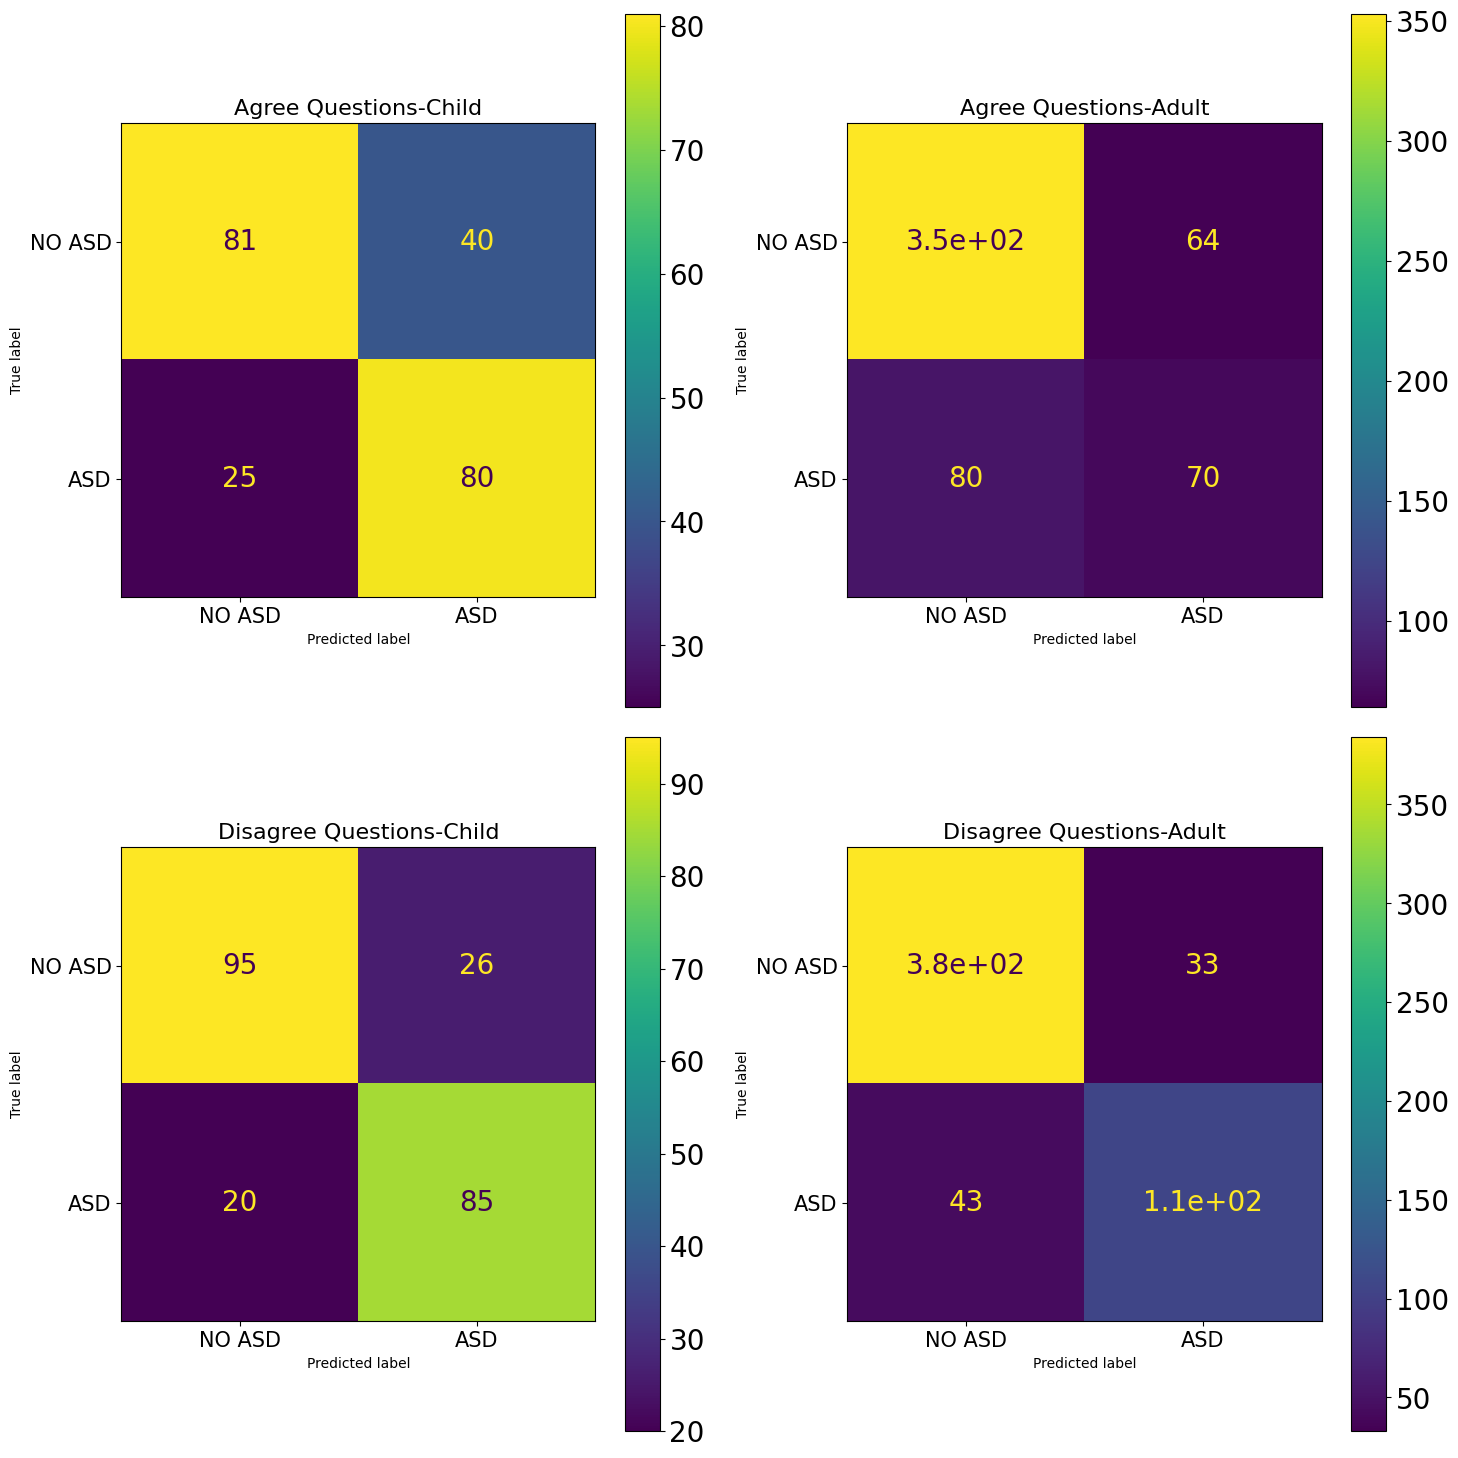

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
plt.rcParams.update({'font.size':20})

# Calculate and plot the confusion matrices for Agree Questions-Child
cm0_display = ConfusionMatrixDisplay(child_agree_cm, display_labels=['NO ASD', 'ASD'])
cm0_display.plot(ax=axes[0, 0])
axes[0, 0].set_title('Agree Questions-Child', fontsize=16)
axes[0,0].tick_params(axis='both', which='major', labelsize=15)

# Calculate and plot the confusion matrices for Disagree Questions-Child
cm1_display = ConfusionMatrixDisplay(child_disagree_cm, display_labels=['NO ASD', 'ASD'])
cm1_display.plot(ax=axes[1, 0])
axes[1, 0].set_title('Disagree Questions-Child', fontsize=16)
axes[1,0].tick_params(axis='both', which='major', labelsize=15)

# Calculate and plot the confusion matrices for Agree Questions-Adult
cm2_display = ConfusionMatrixDisplay(adult_agree_cm, display_labels=['NO ASD', 'ASD'])
cm2_display.plot(ax=axes[0, 1])
axes[0, 1].set_title('Agree Questions-Adult', fontsize=16)
axes[0,1].tick_params(axis='both', which='major', labelsize=15)

# Calculate and plot the confusion matrices for Disagree Questions-Adult
cm3_display = ConfusionMatrixDisplay(adult_disagree_cm, display_labels=['NO ASD', 'ASD'])
cm3_display.plot(ax=axes[1, 1])
axes[1, 1].set_title('Disagree Questions-Adult',fontsize=16)
axes[1,1].tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()
fig.savefig('ASD-CM.png')



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c4f6706-b795-4080-9d47-8d1e07abe98f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>